In [70]:
import pandas as pd
import json
import requests
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from sklearn.preprocessing import StandardScaler
import ta



In [71]:
btc_df = pd.read_csv('data/btc_201901_202411.csv')

btc_df['close_tomro'] = btc_df['close'].shift(-1)

## volume USD
btc_df['volume_usd'] = btc_df['close']*btc_df['volume']

##lag
for i in range(1, 9):
    btc_df[f'close_{i}'] = btc_df['close'].shift(i)
    btc_df[f'volume_{i}'] = btc_df['volume_usd'].shift(i)

## STD+Mean -> bbands
btc_df['bb_middle'] = btc_df['close'].rolling(window=20).mean()
btc_df['bb_std'] = btc_df['close'].rolling(window=20).std()
btc_df['bb_upper'] = btc_df['bb_middle'] + (2 * btc_df['bb_std'])
btc_df['bb_lower'] = btc_df['bb_middle'] - (2 * btc_df['bb_std'])

## OBV
btc_df['obv'] = (np.sign(btc_df['close'].diff()) * btc_df['volume_usd']).fillna(0).cumsum()



# cols_to_pct = ['open','high','low','close','volume','close_tomro','volume_usd',
#                     'close_1','close_2','close_3','close_4','close_5','close_6','close_7','close_8',
#                     'volume_1','volume_2','volume_3','volume_4','volume_5','volume_6','volume_7','volume_8',
                     
#                     ]
# btc_df[cols_to_pct] = btc_df[cols_to_pct].pct_change() * 100

# Assuming btc_df is your DataFrame and has 'close' and 'high', 'low', and 'volume' columns for these calculations

# Moving Averages
btc_df['MA5'] = btc_df['close'].rolling(window=5).mean()
btc_df['MA10'] = btc_df['close'].rolling(window=10).mean()
btc_df['MA20'] = btc_df['close'].rolling(window=20).mean()
btc_df['MA50'] = btc_df['close'].rolling(window=50).mean()
btc_df['MA200'] = btc_df['close'].rolling(window=200).mean()

# Exponential Moving Averages
btc_df['EMA10'] = btc_df['close'].ewm(span=10, adjust=False).mean()
btc_df['EMA20'] = btc_df['close'].ewm(span=20, adjust=False).mean()
btc_df['EMA50'] = btc_df['close'].ewm(span=50, adjust=False).mean()
btc_df['EMA100'] = btc_df['close'].ewm(span=100, adjust=False).mean()
btc_df['EMA200'] = btc_df['close'].ewm(span=200, adjust=False).mean()

# MACD and Signal Line (MACD_EMA)
btc_df['MACD'] = btc_df['close'].ewm(span=12, adjust=False).mean() - btc_df['close'].ewm(span=26, adjust=False).mean()
btc_df['MACD_EMA'] = btc_df['MACD'].ewm(span=9, adjust=False).mean()

# Average True Range (ATR)
btc_df['ATR'] = ta.volatility.average_true_range(btc_df['high'], btc_df['low'], btc_df['close'], window=14)

# Average Directional Index (ADX)
btc_df['ADX'] = ta.trend.adx(btc_df['high'], btc_df['low'], btc_df['close'], window=14)

# Commodity Channel Index (CCI)
btc_df['CCI'] = ta.trend.cci(btc_df['high'], btc_df['low'], btc_df['close'], window=20)

# Rate of Change (ROC)
btc_df['ROC'] = ta.momentum.roc(btc_df['close'], window=12)

# Relative Strength Index (RSI)
btc_df['RSI'] = ta.momentum.rsi(btc_df['close'], window=14)


# Stochastic Oscillator %K (SO%K)
btc_df['SO%K'] = ta.momentum.stoch(btc_df['high'], btc_df['low'], btc_df['close'], window=14, smooth_window=3)

# Standard Deviation (STD) over 5 periods
btc_df['STD5'] = btc_df['close'].rolling(window=5).std()



btc_df.dropna(inplace=True)

In [72]:
btc_df.head()

,Unnamed: 0,date,open,high,low,close,volume,close_tomro,volume_usd,close_1,...,EMA200,MACD,MACD_EMA,ATR,ADX,CCI,ROC,RSI,SO%K,STD5
199,199,2019-07-19,10638.44,10776.99,10102.58,10535.43,13787.456467,10750.11,1.452568e+08,10648.60,...,7028.048102,7.706129,255.554852,1075.880376,20.822517,-65.452134,-8.147631,48.880121,35.800610,632.909840
200,200,2019-07-20,10533.71,11120.00,10359.17,10750.11,9964.673883,10600.24,1.071213e+08,10535.43,...,7065.083544,8.330018,206.109885,1053.376778,19.438414,-33.320065,-12.502137,50.269565,40.973049,609.562556
201,201,2019-07-21,10757.15,10839.09,10325.00,10600.24,5628.161767,10328.83,5.965987e+07,10750.11,...,7100.259230,-3.231550,164.241598,1014.856294,18.106091,-49.704998,-15.651739,49.262914,37.362124,425.088460
202,202,2019-07-22,10605.03,10686.89,10052.25,10328.83,9371.306442,9847.02,9.679463e+07,10600.24,...,7132.384312,-33.903873,124.612504,987.697987,17.137516,-72.871344,-14.630360,47.411296,30.822849,157.206220
203,203,2019-07-23,10315.87,10327.33,9801.88,9847.02,9040.848826,9763.67,8.902542e+07,10328.83,...,7159.395613,-95.983511,80.493301,954.787417,16.576980,-98.405254,-13.236305,44.232876,19.214256,350.395046


In [73]:
btc_df.columns

Index(['Unnamed: 0', 'date', 'open', 'high', 'low', 'close', 'volume',
       'close_tomro', 'volume_usd', 'close_1', 'volume_1', 'close_2',
       'volume_2', 'close_3', 'volume_3', 'close_4', 'volume_4', 'close_5',
       'volume_5', 'close_6', 'volume_6', 'close_7', 'volume_7', 'close_8',
       'volume_8', 'bb_middle', 'bb_std', 'bb_upper', 'bb_lower', 'obv', 'MA5',
       'MA10', 'MA20', 'MA50', 'MA200', 'EMA10', 'EMA20', 'EMA50', 'EMA100',
       'EMA200', 'MACD', 'MACD_EMA', 'ATR', 'ADX', 'CCI', 'ROC', 'RSI', 'SO%K',
       'STD5'],
      dtype='object')

In [74]:
## Training & Validation model

list_of_cols = [
    'open','high','low','close','volume_usd',
    'close_1','close_2','close_3','close_4','close_5','close_6','close_7','close_8',
    'volume_1','volume_2','volume_3','volume_4','volume_5','volume_6','volume_7','volume_8',
    'bb_middle', 'bb_std', 'bb_upper', 'bb_lower', 'obv', 'MA5',
       'MA10', 'MA20', 'MA50', 'MA200', 'EMA10', 'EMA20', 'EMA50', 'EMA100',
       'EMA200', 'MACD', 'MACD_EMA', 'ATR', 'ADX', 'CCI', 'ROC', 'RSI', 'SO%K',
       'STD5',
    
    'close_tomro'
]

btc_df_train = btc_df[btc_df['date']< '2024-10-01']
btc_df_test = btc_df[btc_df['date']> '2024-10-01']

df = btc_df_train[list_of_cols]

q = btc_df_test[list_of_cols]

In [75]:
df.head()

,open,high,low,close,volume_usd,close_1,close_2,close_3,close_4,close_5,...,MACD,MACD_EMA,ATR,ADX,CCI,ROC,RSI,SO%K,STD5,close_tomro
199,10638.44,10776.99,10102.58,10535.43,1.452568e+08,10648.60,9699.35,9412.81,10850.00,10191.87,...,7.706129,255.554852,1075.880376,20.822517,-65.452134,-8.147631,48.880121,35.800610,632.909840,10750.11
200,10533.71,11120.00,10359.17,10750.11,1.071213e+08,10535.43,10648.60,9699.35,9412.81,10850.00,...,8.330018,206.109885,1053.376778,19.438414,-33.320065,-12.502137,50.269565,40.973049,609.562556,10600.24
201,10757.15,10839.09,10325.00,10600.24,5.965987e+07,10750.11,10535.43,10648.60,9699.35,9412.81,...,-3.231550,164.241598,1014.856294,18.106091,-49.704998,-15.651739,49.262914,37.362124,425.088460,10328.83
202,10605.03,10686.89,10052.25,10328.83,9.679463e+07,10600.24,10750.11,10535.43,10648.60,9699.35,...,-33.903873,124.612504,987.697987,17.137516,-72.871344,-14.630360,47.411296,30.822849,157.206220,9847.02
203,10315.87,10327.33,9801.88,9847.02,8.902542e+07,10328.83,10600.24,10750.11,10535.43,10648.60,...,-95.983511,80.493301,954.787417,16.576980,-98.405254,-13.236305,44.232876,19.214256,350.395046,9763.67


In [76]:
def train_test_funk(df):
    y = df.iloc[:,-1]

    X = df.iloc[:,:-1]
    #X = pd.get_dummies(X, columns=['price_volume_alignment'], drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X, y, X_train, X_test, y_train, y_test

X, y, X_train, X_test, y_train, y_test = train_test_funk(df)

## Oct testing data
oct_x = q.iloc[:,:-1]
oct_y = q.iloc[:,-1]

/Users/harshatamatam/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.15132e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


                      Training MSE   Test MSE  TrainDirection  Test Direction
Model                                                                        
Linear Regression         0.778451   3.217126       98.485846       98.421053
Ridge                     0.778451   3.217122       98.485846       98.421053
Random Forest             0.319781   3.334560       99.144174       98.157895
XGBoost                   0.387395   3.635422       98.551679       97.631579
SVR (SVM Regression)     12.452159  49.516768       90.388413       90.526316
Gradient Boosting         0.552671   3.421044       98.683344       97.894737
K-Nearest Neighbors       2.598442  12.235641       93.153390       92.894737
Bayesian Ridge            0.783845   3.174713       98.420013       98.421053
----------
Oct error:  37.840906883188886
Actual: 60745.0, Predicted: 60646.805211185805, diff: 98.19478881419491
Actual: 62081.0, Predicted: 60300.387522966106, diff: 1780.6124770338938
Actual: 62063.0, Predicted: 61909

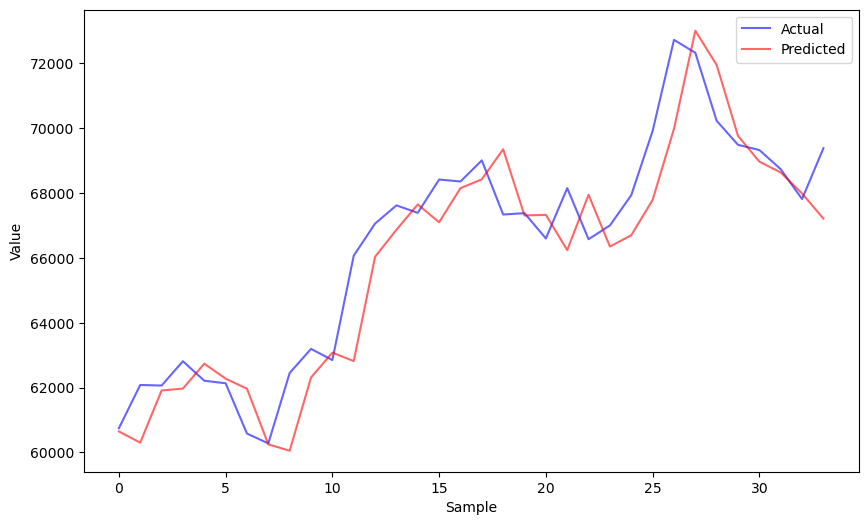

In [77]:

models = {
    "Linear Regression": LinearRegression(),
    #"Lasso": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=0.2),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', alpha=1, max_depth=3, random_state=42),
    #"ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5),
    "SVR (SVM Regression)": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Bayesian Ridge": BayesianRidge()
}

feature_names = X.columns.tolist()

# Collect results
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_mse = math.sqrt(mean_squared_error(y_train, train_pred))/X_train.shape[0]
    test_mse = math.sqrt(mean_squared_error(y_test, test_pred))/X_test.shape[0]

    y_train_np = np.array(y_train)
    y_train_np = np.diff(y_train_np)/y_train_np[:-1]
    train_pred_np = np.array(train_pred)
    train_pred_np = np.diff(train_pred_np)/train_pred_np[:-1]
    y_test_np = np.array(y_test)
    y_test_np = np.diff(y_test_np)/y_test_np[:-1]
    test_pred_np = np.array(test_pred)
    test_pred_np = np.diff(test_pred_np)/test_pred_np[:-1]
    correct_directions_train = np.sign(y_train_np) == np.sign(train_pred_np)
    directional_accuracy_train = correct_directions_train.mean() * 100 
    correct_directions_test = np.sign(y_test_np) == np.sign(test_pred_np)
    directional_accuracy_test = correct_directions_test.mean() * 100 
    results.append([name, train_mse, test_mse, directional_accuracy_train, directional_accuracy_test])


# Convert results to DataFrame for display
results_df = pd.DataFrame(results, columns=["Model", "Training MSE", "Test MSE", "TrainDirection","Test Direction"])
results_df.set_index('Model',inplace=True)
print(results_df)
print("----------")

##########
## Testing on oct month
test_model = LinearRegression()
test_model.fit(X_train, y_train)
oct_pred = test_model.predict(oct_x)
oct_mse = mean_squared_error(oct_y, oct_pred)
print("Oct error: ",math.sqrt(oct_mse)/35)
total_count = 0
high_diff = 0
for actual, predicted in zip(oct_y, oct_pred):
    total_count += 1
    if actual-predicted > 1000:
        high_diff += 1
    print(f"Actual: {actual}, Predicted: {predicted}, diff: {actual-predicted}" )
print(high_diff, total_count)
plt.figure(figsize=(10, 6))
plt.plot(oct_y.values, label="Actual", color="blue", alpha=0.6, )
plt.plot(oct_pred, label="Predicted", color="red", alpha=0.6)
plt.xlabel("Sample")
plt.ylabel("Value")
# plt.ylim(-10, 10)
plt.legend()
plt.show()

In [79]:
models['Linear Regression'].coef_

array([-1.73803586e+00,  1.11021090e-01,  1.09633475e-01,  3.87282929e+00,
        1.32993149e-06,  3.75576966e+00,  1.33506611e+00,  7.45083388e-01,
        3.79543784e-01,  5.11016189e-01,  3.07771450e-01,  1.09082791e-01,
        1.84794666e-01, -8.93282456e-07, -6.46221410e-08, -1.73488871e-06,
        1.44914654e-06, -1.03826764e-06,  7.86585115e-07, -1.11076348e-06,
       -3.87855726e-07, -3.26110813e-01,  1.54620770e-02, -2.95189461e-01,
       -3.57039757e-01,  9.84428200e-08,  2.01763382e+00,  3.57597773e-01,
       -3.26110813e-01,  1.47218120e-01, -2.22206455e-02,  3.07686101e+01,
       -3.85470613e+01, -2.78016245e+00,  8.35647691e-01, -1.76964245e-01,
       -7.33030485e+01,  3.63394445e+01, -1.39199248e-01,  7.57332283e-01,
       -7.64407615e-01,  3.45805327e+00,  9.99373452e-02,  3.01978704e+00,
        9.94349414e-02])